In [225]:
import itertools                 # permutations
import numpy as np               # computations
import matplotlib.pyplot as plt  # plotting
from tqdm import tqdm            # time of for loops
from timeit import default_timer as timer # timer

# import our own modules
import sys
sys.path.append("..")

# import our own helper
import helper.helper as h

# import NOTEARS
from notears.notears.notears import linear
from notears.notears.notears import utils

### NOTEARS and OMP with different noise levels, an analysis
NOTEARS (and OMP) always seem to be able to predict the correct **direction**, even in just two dimensions. How is this possible? This is most likely when we have **equal** *variance* across all variables, e.g. additive noise with variance 1. However, what happens when *variance* levels are **unequal**? Will NOTEARS still perform well? Let us find out.

True model:
\begin{align*} X &= \varepsilon_X &\varepsilon_X, \sim \mathcal{N}(0, \sigma_1^2) \\
Y &= bX + \varepsilon_Y, &\varepsilon_Y \sim \mathcal{N}(0, \sigma_2^2)\end{align*}

OR Opposite direction model:
\begin{align*} X &= cY + \varepsilon'_X &\varepsilon'_X, \sim \mathcal{N}(0, \sigma_1'^2) \\
Y &= \varepsilon'_Y, &\varepsilon'_Y \sim \mathcal{N}(0, \sigma_2'^2)\end{align*}

### Generate Data according to True model

In [390]:
s1, s2 = np.random.random(), np.random.random()
b = np.random.random() # np.sqrt(1 - s2 ** 2 / s1 ** 2)

T, n, s0, graph_type, sem_type = 10000, 2, 1, 'ER', 'gauss'
W_true = np.array([[0.0, b], [0.0, 0.0]])
X = utils.simulate_linear_sem(W_true, T, sem_type, noise_scale = [s1, s2])
X -= np.mean(X, axis = 0)

### Find value for $b$ (true model) and $c$ (opposite direction model)

In [430]:
W1 = np.zeros((n, n))
W1[0][1] = 1 / (X[:, 0].T @ X[:, 0]) * X[:, 0].T @ X[:, 1]
print(f"b:  {round(1 / (X[:, 0].T @ X[:, 0]) * X[:, 0].T @ X[:, 1], 5)}. Should be close to: {round(b, 5)}.")
print(f"Corresponding W1:\n{np.round(W1, 3)}.\n")

W2 = np.zeros((n, n))
W2[1][0] = 1 / (X[:, 1].T @ X[:, 1]) * X[:, 1].T @ X[:, 0]
print(f"c: {round(1 / (X[:, 1].T @ X[:, 1]) * X[:, 1].T @ X[:, 0], 5)}. Should be close to: {round(b * s1 ** 2 / (b ** 2 * s1 ** 2 + s2 ** 2), 5)}.")
print(f"Corresponding W2:\n{np.round(W2, 3)}.\n")

print(f"MSE using W1: {round(h.MSE(W1, X, is_sem = True), 8)}.")
print(f"MSE using W2: {round(h.MSE(W2, X, is_sem = True), 8)}.")

b:  -0.29419. Should be close to: -0.29492.
Corresponding W1:
[[ 0.    -0.294]
 [ 0.     0.   ]].

c: -3.35032. Should be close to: -3.34124.
Corresponding W2:
[[ 0.    0.  ]
 [-3.35  0.  ]].

MSE using W1: 0.46881131.
MSE using W2: 0.04784406.


## Q1: Which one does NOTEARS pick?

In [431]:
W_NOTEARS, h_val = linear.notears_linear(X, lambda1 = 0, loss_type = "l2", verbose = False, w_threshold = 1e-2)

# does NOTEARS pick the one minimizing the MSE?
print(f"Does NOTEARS pick the direction minimizing the MSE? {h.MSE(W_NOTEARS, X,  is_sem = True) - 1e-3 <= min(h.MSE(W1, X, is_sem = True), h.MSE(W2, X, is_sem = True))}.")
print(f"Is this the 'correct' direction? {np.nonzero(W_NOTEARS) == np.nonzero(W1)}.")

Does NOTEARS pick the direction minimizing the MSE? True.
Is this the 'correct' direction? False.


### Is this always?

In [249]:
for _ in range(10):
    b, s1, s2 = np.random.random(), np.random.random(), np.random.random()
    W_true = np.array([[0.0, b], [0.0, 0.0]])
    X = utils.simulate_linear_sem(W_true, T, sem_type, noise_scale = [s1, s2])
    X -= np.mean(X, axis = 0)

    W1 = np.zeros((n, n))
    W1[0][1] = 1 / (X[:, 0].T @ X[:, 0]) * X[:, 0].T @ X[:, 1]
    
    W2 = np.zeros((n, n))
    W2[1][0] = 1 / (X[:, 1].T @ X[:, 1]) * X[:, 1].T @ X[:, 0]

    W_NOTEARS, h_val = linear.notears_linear(X, lambda1 = 0, loss_type = "l2", verbose = False, w_threshold = 1e-2)
    
    print(f"Does NOTEARS pick the direction minimizing the MSE? {h.MSE(W_NOTEARS, X,  is_sem = True) - 1e-3 <= min(h.MSE(W1, X, is_sem = True), h.MSE(W2, X, is_sem = True))}. Is this the 'correct' direction? {np.nonzero(W_NOTEARS) == np.nonzero(W1)}.")

Does NOTEARS pick the direction minimizing the MSE? True. Is this the 'correct' direction? True.
Does NOTEARS pick the direction minimizing the MSE? True. Is this the 'correct' direction? True.
Does NOTEARS pick the direction minimizing the MSE? True. Is this the 'correct' direction? True.
Does NOTEARS pick the direction minimizing the MSE? True. Is this the 'correct' direction? True.
Does NOTEARS pick the direction minimizing the MSE? True. Is this the 'correct' direction? True.
Does NOTEARS pick the direction minimizing the MSE? True. Is this the 'correct' direction? True.
Does NOTEARS pick the direction minimizing the MSE? True. Is this the 'correct' direction? True.
Does NOTEARS pick the direction minimizing the MSE? True. Is this the 'correct' direction? False.
Does NOTEARS pick the direction minimizing the MSE? True. Is this the 'correct' direction? True.
Does NOTEARS pick the direction minimizing the MSE? True. Is this the 'correct' direction? False.


## Q2: What is the expected value for $c$?
Now, we see that NOTEARS always picks the direction that minimizes the MSE. As a follow-up question, what is the value for the incorrect direction? We know they are the solutions to OLS, but what are they analytically?

Intuitively, one could think that $c$ would be $1 / b$. So, if $X = 2Y$, then the $c$ that minimizes the MSE on the training data would be $c = 1 / b = 0.5$. This is, however, not the case. 

To see why, suppose $\sigma_2$ is very large, then $Y$ is almost purely random noise, no matter the values for $b$. Then, if we try to predict $X$ using $Y$, we try to predict $X$ using random noise. Obviously, the “optimal” choice would then be to pick $c = 0$, and not $1 / b$. 

Therefore, we see that the value for $c$ depends on $a$ and the ratio of noise, so the ratio of $\sigma_1$ and $\sigma_2$. It turns out that the expected value for $c$ will be $$c = \frac{b\sigma_1^2}{b^2 \sigma_1^2 + \sigma_2^2}.$$ To see why, consider the following derivation.

\begin{align} c' &= \underset{c}{\arg \min}\ \text{MSE}(W_2) \\ &= \underset{c}{\arg \min}\ \mathbb{V}\left(X - cY\right) & \text{Only part with $c$ in it.} \\ &= \underset{c}{\arg \min}\ \mathbb{V}(X - c(bX + \varepsilon_Y)) & \text{Definition of $Y$}\\ &= \underset{c}{\arg \min}\ \mathbb{V}(X(1-cb) + c\varepsilon_Y) & \text{Rewrite.}\\ &= \underset{c}{\arg \min}\ (1 -cb)^2\mathbb{V}(X) + c^2 \mathbb{V}(\varepsilon_Y) & \text{Take out constants.}\\ &= \underset{c}{\arg \min}\ (1 -cb)^2 \mathbb{V}(\varepsilon_X) + c^2 \mathbb{V}(\varepsilon_Y) & \text{Definition of $X$}\\&= \underset{c}{\arg \min}\ (1 - cb)^2 \sigma_1^2 + c^2 \sigma_2^2. & \text{Definition of $X$ and $Y$.}\end{align}

Setting derivative to zero yields $$c = \frac{b\sigma_1^2}{b^2 \sigma_1^2 + \sigma_2^2}$$

In [426]:
c_true = b * s1 ** 2 / (b ** 2 * s1 ** 2 + s2 ** 2)

W = np.array([[0.0, 0.0], [c_true, 0.0]])
print(np.var(X - X @ W, axis = 0)[0])
print(f"Step 0: {h.MSE(W, X, is_sem = True) - b ** 2 * s1 ** 2 - s2 ** 2}.")
print(f"Step 1: {np.var(X[:, 0] - c_true * X[:, 1])}.")
print(f"Step 2: {np.var(X[:, 0] - c_true * (b * X[:, 0])) + c_true ** 2 * s2 ** 2}.")
print(f"Step 3: {np.var(X[:, 0] - c_true * b * X[:, 0]) + c_true ** 2 * s2 ** 2}.")
print(f"Step 4: {np.var(X[:, 0] - c_true * b * X[:, 0]) + c_true ** 2 * s2 ** 2}.")
print(f"Step 5: {np.var(X[:, 0] - c_true * b * X[:, 0]) + c_true ** 2 * s2 ** 2}.")
print(f"Step 6: {np.var(X[:, 0]) * (1 - b * c_true) ** 2 + c_true ** 2 * s2 ** 2}.")

0.006733231036535798
Step 0: 0.007300118530541345.
Step 1: 0.006733231036535802.
Step 2: 0.006703574376511454.
Step 3: 0.006703574376511455.
Step 4: 0.006703574376511455.
Step 5: 0.006703574376511455.
Step 6: 0.006703574376511455.


#### Another Verification

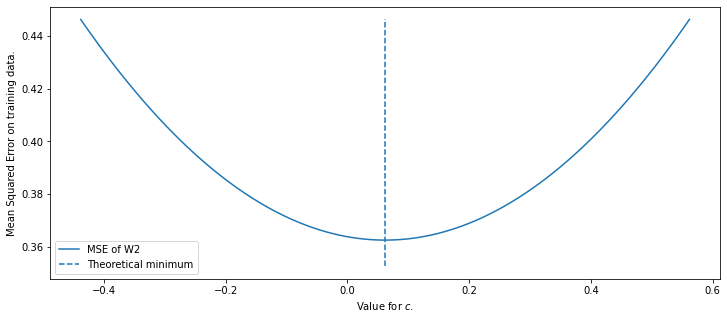

In [389]:
c_vals = np.linspace(b * s1 ** 2 / (b ** 2 * s1 ** 2 + s2 ** 2) - 0.5, b * s1 ** 2 / (b ** 2 * s1 ** 2 + s2 ** 2) + 0.5, 100)
to_plot = []
for c in c_vals:
    W = np.array([[0.0, 0.0], [c, 0.0]])
    to_plot.append(h.MSE(W, X, is_sem = True))

plt.figure(figsize = (12, 5))
plt.xlabel(r"Value for $c$.")
plt.ylabel(r"Mean Squared Error on training data.")
plt.plot(c_vals, to_plot, label = "MSE of W2")
plt.vlines(c_true, min(to_plot) - 0.01, max(to_plot), linestyle = '--', label = "Theoretical minimum")
plt.legend()

## Q3: When do we pick $W_1$, and when do we pick $W_2$?
We now know that NOTEARS / OMP picks the direction that minimizes the MSE, and we now also know what the coefficient for the opposite direction would be. Now the most difficult question, when do we pick which direction?

By definition, we pick $W_1$, the correct direction, when 

\begin{align}\mathbb{E}[\text{MSE}(W_1)] < \mathbb{E}[\text{MSE}(W_2)] &\iff \mathbb{E}[||X - W_1X||_2^2] < \mathbb{E}[||X - W_2X||_2^2],\end{align}

where $$W_1 = \begin{pmatrix} 0 & b \\ 0 & 0 \end{pmatrix}, \qquad \begin{pmatrix} 0 & 0 \\ c & 0 \end{pmatrix}.$$

### Deriving $\mathbb{E}[\text{MSE}(W_1)]$.
Now, $$\mathbb{E}[||X - W_1X||_2^2] = \mathbb{E}\left[\left(X - 0\right)^2\right] + \mathbb{E}\left[\left(Y - bX\right)^2\right].$$ 

Using the fact that both $X$ and $Y$ have zero mean, we can continue with 

$$\mathbb{E}\left[\left(X - 0\right)^2\right] + \mathbb{E}\left[\left(Y - bX\right)^2\right] = \mathbb{V}(X) + \mathbb{V}\left(Y - bX\right).$$

Since we know how the data was generated, we know that 

$$\mathbb{V}(X) = \mathbb{V}(\varepsilon_X) = \sigma_1^2,\qquad\text{and}\qquad\mathbb{V}\left(Y - bX\right) = \mathbb{V}(bX + \varepsilon_Y - bX) = \mathbb{V}(\varepsilon_Y) = \sigma_2^2.$$ 

Therefore, we can conclude that $$\mathbb{E}[\text{MSE}(W_1)] = \sigma_1^2 + \sigma_2^2.$$

### Deriving $\mathbb{E}[\text{MSE}(W_2)]$.
Now, $$\mathbb{E}[||X - W_2X||_2^2] = \mathbb{E}\left[\left(X - cY\right)^2\right] + \mathbb{E}\left[\left(Y - 0\right)^2\right].$$ 

Using the fact that both $X$ and $Y$ have zero mean, we can continue with 

$$\mathbb{E}\left[\left(X - cY\right)^2\right] + \mathbb{E}\left[\left(Y - 0\right)^2\right] = \mathbb{V}(X - cY) + \mathbb{V}\left(Y\right).$$

Since we know how the data was generated, we know that 

\begin{align} \mathbb{V}(X - cY) &= (1 - bc)\sigma_1^2. & \text{(This derivation was the most difficult)}\end{align}

$$\mathbb{V}\left(Y\right) = \mathbb{V}(bX + \varepsilon_Y) = \mathbb{V}(b \varepsilon_X + \varepsilon_Y) = b^2 \mathbb{V}(\varepsilon_X) + \mathbb{V}(\varepsilon_Y) = b^2 \sigma_1^2 + \sigma_2^2.$$ 

Therefore, we can conclude that $$\mathbb{E}[\text{MSE}(W_2)] = (1 - bc)\sigma_1^2 + b^2 \sigma_1^2 + \sigma_2^2.$$

### Putting it all together.
Now that we have rewritten both expected mean squared errors to known quantitities, we can determine in which scenarios $W_1$ is better, and in which scenarios $W_2$ is better.

\begin{align}\mathbb{E}[\text{MSE}(W_1)] < \mathbb{E}[\text{MSE}(W_2)] &\iff \sigma_1^2 + \sigma_2^2 < \left(1 - bc\right) \sigma_1^2 + b^2\sigma_1^2 + \sigma_2^2 & \text{Fill in derivations for MSEs} \\ &\iff 0 < (b^2 - bc)\sigma_1 ^2 & \text{Remove $\sigma_1^2 + \sigma_2^2$ from both sides}\\&\iff bc < b^2 & \text{Divide by $\sigma_1^2$, rearrange} \\ &\iff \frac{b^2 \sigma_1^2}{b^2\sigma_1^2 + \sigma_2^2} < b^2 & \text{Fill in $c$} \\&\iff \frac{\sigma_1^2}{b^2\sigma_1^2 + \sigma_2^2} < 1 & \text{Divide by $b^2$} \\ &\iff \sigma_1^2 < b^2\sigma_1^2 + \sigma_2^2 & \text{Multiply by denominator} \\&\iff b^2 \sigma_1^2 > \sigma_1^2 - \sigma_2^2 & \text{Rearrange} \\ &\iff b^2 > 1 - \frac{\sigma_2^2}{\sigma_1^2} & \text{Divide by $\sigma_1^2$}\end{align}

So, after some moderately difficult derivations, we end up at a very easy condition! 
- Note that when $|b| > 1$, then we will always pick the correct one. 
- However, when $|b| < 1$, we might pick the wrong one. 
    - Still, we will never pick the wrong one when $\sigma_1 \leq \sigma_2$, as we then have $b^2 > 0 > 1 - \left(\frac{\sigma_1}{\sigma_2}\right)^2$. 
    - Then, when $\sigma_1 > \sigma_2$, we pick the wrong one when $b^2 < 1 - \left(\frac{\sigma_2}{\sigma_1}\right)^2 $.
    
In words:
- When Y is an amplification fo X (so |b| > 1), then we will always pick the correct one, as the noise is also amplified as well.
- However, when this is not the case, we might pick the wrong direction.
    - We do this for certain when measurements in Y are noisier than measurements in X.
    - We might do this when measurements in X are noiser than measurements in Y, but this depends on the value of $b$ and the noise ratio between $X$ and $Y$.

#### Verification of MSE components

In [428]:
print("First approach, proper model fit (W1).")
print(f"MSE of X1: {round(np.var(X, axis = 0)[0], 3)}. Should be close to {round(s1 ** 2, 3)}.")
print(f"MSE of X2: {round(np.var(X[:, 1] - W1[0][1] * X[:, 0]), 3)}. Should be close to {round(s2 ** 2, 3)}.")

print("\nSecond approach, incorrect model fit (W2).")
print(f"MSE of X1: {round(np.var(X, axis = 0)[0] * (1 - W1[0][1] * W2[1][0]), 3)}. Should be close to {round(s1 ** 2 * (1 - b * c_true), 3)}")
print(f"MSE of X2: {round(np.var(X, axis = 0)[1], 3)}. Should be close to {round(b ** 2 * s1 ** 2 + s2 ** 2, 3)}.")

First approach, proper model fit (W1).
MSE of X1: 0.468. Should be close to 0.459.
MSE of X2: 0.001. Should be close to 0.001.

Second approach, incorrect model fit (W2).
MSE of X1: 0.007. Should be close to 0.007
MSE of X2: 0.041. Should be close to 0.041.


#### Verification of total MSE

In [429]:
print(f"MSE(W1): {round(h.MSE(W1, X, True), 3)}, should be close to {round(s1 ** 2 + s2 ** 2, 3)}.")
print(f"MSE(W2): {round(h.MSE(W2, X, True), 3)}, should be close to {round(s1 ** 2 * (1 - b * (b * s1 ** 2 / (b ** 2 * s1 ** 2 + s2 ** 2))) + b ** 2 * s1 ** 2 + s2 ** 2, 3)}.")
print(f"Pick W1 if {round(b ** 2 + (s2 / s1) ** 2, 3)} is larger than 1.")

MSE(W1): 0.469, should be close to 0.46.
MSE(W2): 0.048, should be close to 0.047.
Pick W1 if 0.088 is larger than 1.


#### Verification multiple times
Note that we are talking about expectation, when $T$ is not large enough, difficutl cases might swing to the other side due to randomness. Therefore, we pick a moderately large $T$, but we still expect to be wrong sometimes.

In [425]:
T = 10000

correct = 0
incorrect = 0

for _ in range(1000):
    # get a, s1, s2
    b, s1, s2 = np.random.choice([-1, 1]) * np.random.random(), np.random.random(), np.random.random()
    
    # remake W
    W_true = np.array([[0.0, b], [0.0, 0.0]])
    
    # generate X
    X = utils.simulate_linear_sem(W_true, T, sem_type, noise_scale = [s1, s2])
    
    # do NOTEARS
    W_NOTEARS, h_val = linear.notears_linear(X, lambda1 = 0, loss_type = "l2", verbose = False, w_threshold = 1e-4)
    
    # Verify    
    if len(W_NOTEARS[W_NOTEARS != 0]) == 1:
        print(f"Pick W1 if {round(b ** 2 + (s2 / s1) ** 2, 2)} is larger than 1. => {(b ** 2 + (s2 / s1) ** 2 > 1) == (W_NOTEARS[0][1] != 0)}.\tMinimizes MSE:", end = ' ')

        if (b ** 2 + (s2 / s1) ** 2 > 1) != (W_NOTEARS[0][1] != 0) :
            print(b, s1, s2)
            incorrect += 1
        else:
            correct += 1

        W2 = np.zeros((n, n))
        W2[1][0] = 1 / (X[:, 1].T @ X[:, 1]) * X[:, 1].T @ X[:, 0]

        W1 = np.zeros((n, n))
        W1[0][1] = 1 / (X[:, 0].T @ X[:, 0]) * X[:, 0].T @ X[:, 1]

        # print(a ** 2 + (s2 / s1) ** 2 > 1)
        print(h.MSE(W_NOTEARS, X,  is_sem = True) - 1e-3 <= min(h.MSE(W1, X, is_sem = True), h.MSE(W2, X, is_sem = True))) # , h.MSE(W1, X, is_sem = True), h.MSE(W2, X, is_sem = True))

print(incorrect, correct)

Pick W1 if 0.65 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 5.71 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 7.27 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.24 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 27.52 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.26 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.25 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.21 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 10.79 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.72 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.68 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.21 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.41 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.32 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.12 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 8.6 is larger than 1. => True.	Minimizes M

..\notears\notears\notears\linear.py:73: RuntimeWarning: invalid value encountered in double_scalars
  obj = loss + 0.5 * rho * h * h + alpha * h + lambda1 * w.sum()


Pick W1 if 1.0 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.25 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 3.49 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 2.46 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 142.78 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 12.64 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 4029.77 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.2 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.54 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.48 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 8.06 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.1 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 29.71 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.46 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.54 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.1 is larger than 1. => True.	Minimizes

..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


 True
Pick W1 if 0.72 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 6.4 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 20.29 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.05 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.76 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 13.33 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.71 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 2.8 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.47 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 3.85 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 53.21 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.79 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.15 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.42 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 54.03 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.65 is larger than 1. => True.	Mini

Pick W1 if 0.83 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.95 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.61 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.99 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.96 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.81 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 3.0 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 34.74 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.93 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.59 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.58 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.07 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 100.87 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.37 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.45 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.81 is larger than 1. => True.	Minimizes 

Pick W1 if 1.72 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.23 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.23 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.31 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 4.87 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 3.47 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 20.03 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.71 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.01 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 28.61 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 5.63 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 11.15 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 5.12 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.61 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.68 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.29 is larger than 1. => True.	Minimizes

Pick W1 if 2.44 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.95 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.14 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.95 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.04 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.33 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.41 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.01 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.98 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.72 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.31 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.48 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 2.9 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 2.22 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 13.86 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.88 is larger than 1. => True.	Minimizes MS

Pick W1 if 0.87 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.22 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.93 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.12 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.26 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.72 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 19.54 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 2.04 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.58 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 3.38 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.66 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.44 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.3 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.52 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.73 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.65 is larger than 1. => True.	Minimizes MS

Pick W1 if 0.75 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.55 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.05 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.7 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 671.75 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.31 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 19.91 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 2.23 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.07 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 6.84 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.67 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 2.3 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.8 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 5.55 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 1.62 is larger than 1. => True.	Minimizes MSE: True
Pick W1 if 0.49 is larger than 1. => True.	Minimizes MS

### Interesting Remarks
We have seen that the direction depends on the noise level ratio and the amplification factor $b$. Now, for a given noise level ratio $\frac{\sigma_2}{\sigma_1} < 1$, we can see that we need to pick $b = \pm \sqrt{1 - \left(\frac{\sigma_2}{\sigma_1}\right)^2}$, then the value for $c$ equals the value for $b$.

### Follow-Up
We see that in expectation, we have the requirements posed above. However, for small sample size $T$, this is not always the case. A follow-up question would be how large such a $T$ needs to be, or for a given $T$, what is the probability that we draw the same conclusion from generated data as the population setting.